# Referências

https://arxiv.org/pdf/1508.06576.pdf

# Imports

Porque `keras`? Keras permite baixar os pesos de vários classificadores de imagens pre-treinados automaticamente, por isso é uma solução mais simples do que fazer no tensorflow.

Dependências: keras, tensorflow

In [2]:
import numpy as np

from keras import backend as K
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import load_img, img_to_array, array_to_img
from keras.applications import VGG16

from scipy.optimize import fmin_l_bfgs_b

In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12196942857952061881
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 13573413552851796645
physical_device_desc: "device: XLA_CPU device"
]


# Imagens

In [4]:
IMAGE_PATH = 'original.png'
STYLE_PATH = 'style01.png'
OUTPUT_PATH = 'output.png'

SIZE = 512

# Pre-processamento

In [81]:
def pre_process_image(path, size):
    img = load_img(path = path, target_size = (size, size))
    img_array = img_to_array(img)
    img_array = K.variable(preprocess_input(np.expand_dims(img_array, axis = 0)), dtype='float')
    return img_array

image_array = pre_process_image(IMAGE_PATH, SIZE)
style_array = pre_process_image(STYLE_PATH, SIZE)

output = load_img(path = IMAGE_PATH, target_size = (SIZE, SIZE))
output = 0.5 * (img_to_array(output) + np.random.uniform(0, 255, (SIZE, SIZE, 3)))
output = preprocess_input(np.expand_dims(output, axis = 0))
placeholder = K.placeholder(shape = (1, SIZE, SIZE, 3))

# Perda de Conteúdo

Queremos manter as características mais "globais" da imagem. Por exemplo, se trata-se do retrato de uma pessoa, queremos que a imagem continue mostrando uma pessoa depois. Para isso, precisamos manter algumas estruturas maiores: olhos, boca, nariz, contorno do rosto, e assim por diante.

Notação:
- $I$ - imagem original
- $Y$ - imagem gerada
- $MI_c$ - matriz com as features de $I$ para o layer $c$
- $MY_c$ - matriz com as features de $Y$ para o layer $c$

$$L_{content}(I, Y, c) = \frac{1}{2} \sum (MY_c - MI_c)^2$$

In [32]:
#pega as features para diferentes camadas
def features(x, layers, model):
    M = []
    for layer in layers:
        selected = model.get_layer(layer).output
        f_shape = K.shape(selected).eval(session = tf_session)
        feature_matrix = K.reshape(selected, (f_shape[1] * f_shape[2], f_shape[-1]))
        feature_matrix = K.transpose(feature_matrix)
        M.append(feature_matrix)
    return M

def content_loss(content, output):
    return 0.5 * K.sum(K.square(content - output))

# Perda de Estilo

Perda de estilo: preservar o estilo da imagem. Usamos a distância euclidiana entre matrizes de Gram (interpretação: correlação não normalizada).

Matriz de Gram para o layer $c$:
$$G_c = M_c (M_c^T)$$

$GE_c$ e $GY_c$ são, respectivamente, matrizes de Gram para layer $c$ da imagem-estilo e da imagem gerada.

Então a perda de estilo para a camada $c$ é:

$$S_c = \frac{1}{4 n_c^2 m_c^2} \sum(GE_c - GI_c)^2$$

onde $m_c$, $n_c$ são, respectivamente, o tamanho e o número de filtros da camada $c$.

Na rede neural pre-treinada usada para transferência de estilo, layers diferentes correspondem a diferentes níveis de detalhes. Por isso, queremos usar vários layers, gantindo que capturamos detalhes mais finos, mas também características mais "globais" do estilo. Atribuimos um peso $w_c$ para cada layer para deixar a coisa toda mais suave (e controlável).

Enfim, perda de estilo:

$$L_{style}(E, Y, c) = \sum w_c S_c$$

In [33]:
def gram_matrix(feature_matrix):
    return K.dot(feature_matrix, K.transpose(feature_matrix))

def style_loss(weights, outputs, styles):
    loss = K.variable(0.)
    for weight, output, style in zip(weights, outputs, styles):
        size = K.int_shape(output)[1]
        channels = K.int_shape(output)[0]
        output_gram = gram_matrix(output)
        style_gram = gram_matrix(style)
        loss += weight * K.sum(K.square(output_gram - style_gram)) / (4 * (channels**2) * (size**2))
    return loss

# Suavização

(adicionar depois)

# Perda total

Agora, juntamos tudo:

$$L(I, E, Y, c) = \alpha L_{content}(I, Y, c) + \beta L_{style}(E, Y, c)$$

Usando as recomendações do artigo, tomamos $\alpha = 1$ e $\beta$ = $10000$.

In [34]:
def total_loss(placeholder, alpha=1.0, beta=10000.0):
    MY = features(placeholder, layers = content_layers, model = output_model)[0]
    GYs = features(placeholder, layers = style_layers, model = output_model)
    loss_content = content_loss(MY, MI)
    loss_style = style_loss(weights, GYs, GEs)
    return alpha * loss_content + beta * loss_style

# Execução

In [35]:
def calculate_loss(image_array):
    if image_array.shape != (1, SIZE, SIZE, 3):
        image_array = image_array.reshape((1, SIZE, SIZE, 3))
    loss_fcn = K.function([output_model.input], [total_loss(output_model.input)])
    return loss_fcn([image_array])[0].astype('float')

def grad(image_array):
    if image_array.shape != (1, SIZE, SIZE, 3):
        image_array = image_array.reshape((1, SIZE, SIZE, 3))
    grad_function = K.function([output_model.input], K.gradients(total_loss(output_model.input), [output_model.input]))
    return grad_function([image_array])[0].flatten().astype('float')

In [36]:
tf_session = K.get_session()

input_model = VGG16(include_top = False, weights = 'imagenet', input_tensor = image_array)
style_model = VGG16(include_top = False, weights = 'imagenet', input_tensor = style_array)
output_model = VGG16(include_top = False, weights = 'imagenet', input_tensor = placeholder)
content_layers = ['block4_conv2']
style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1',]

MI = features(x = image_array, layers = content_layers, model = input_model)[0]
GEs = features(x = style_array, layers = style_layers, model = style_model)
weights = np.ones(len(style_layers)) / float(len(style_layers))

In [91]:
iterations = 5
x_val = output.flatten()

0


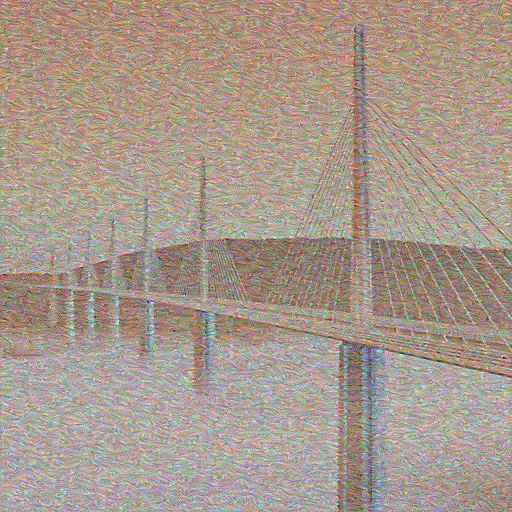

1


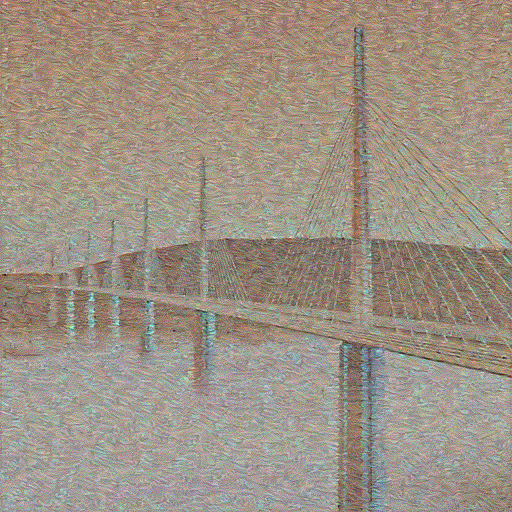

2


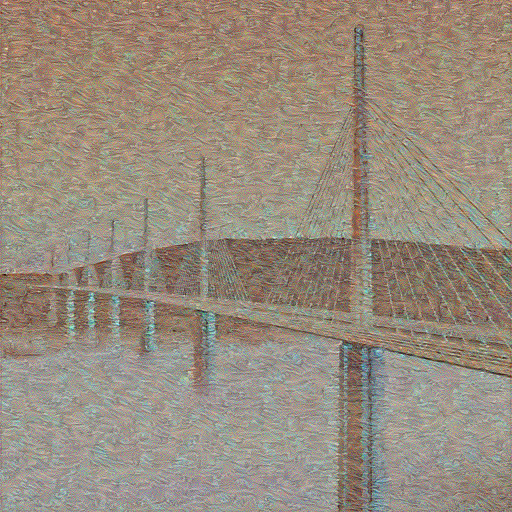

3


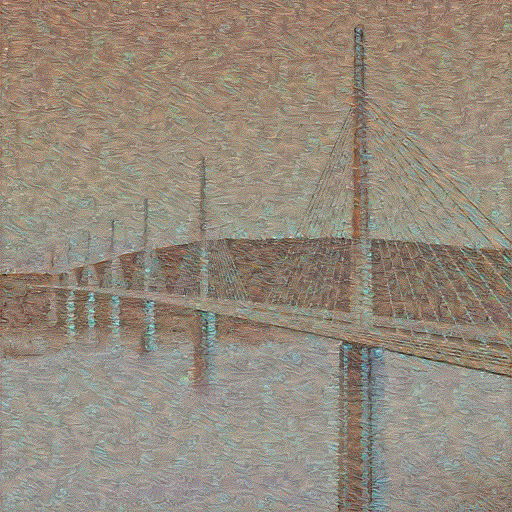

4


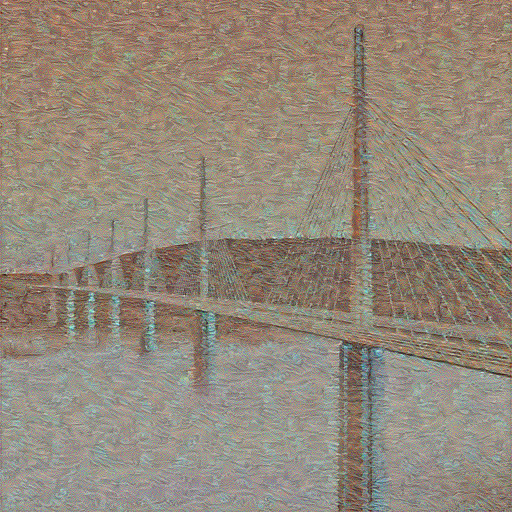

5


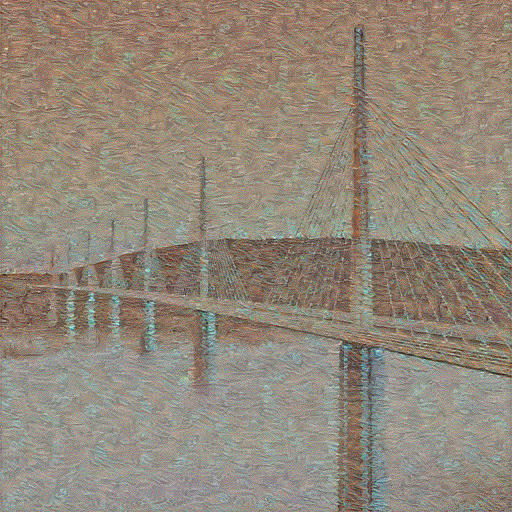

6


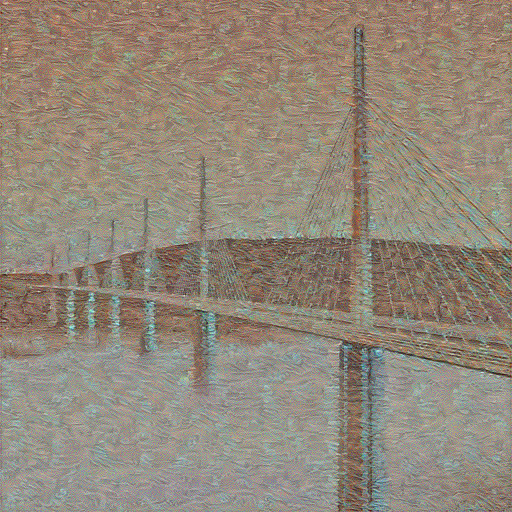

7


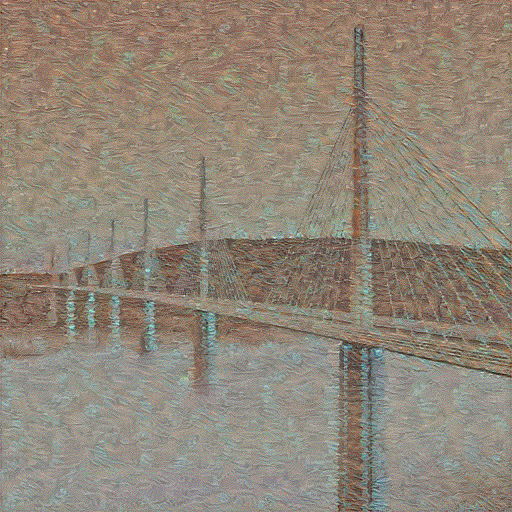

8


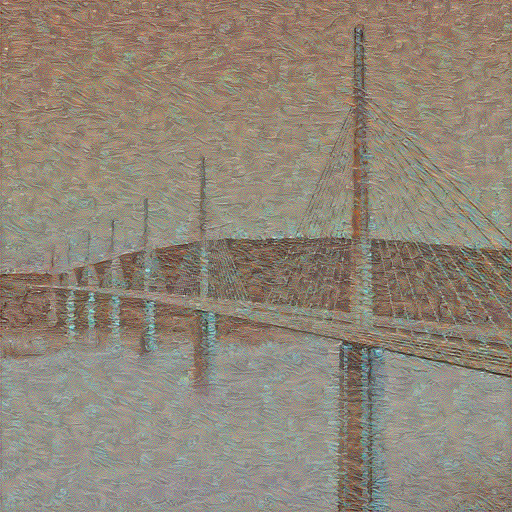

9


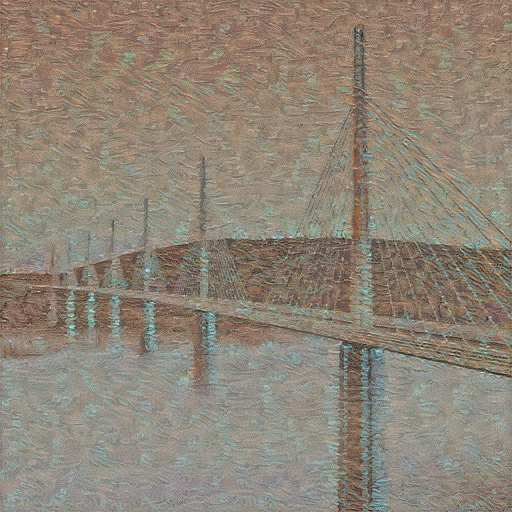

In [92]:
for i in range(int(10)):
    print(i)
    x_val, f_val, info = fmin_l_bfgs_b(calculate_loss, x_val, fprime = grad, maxiter = iterations)
    pred_img = array_to_img(x_val.reshape((SIZE, SIZE, 3)))
    display(pred_img)

(786432,)


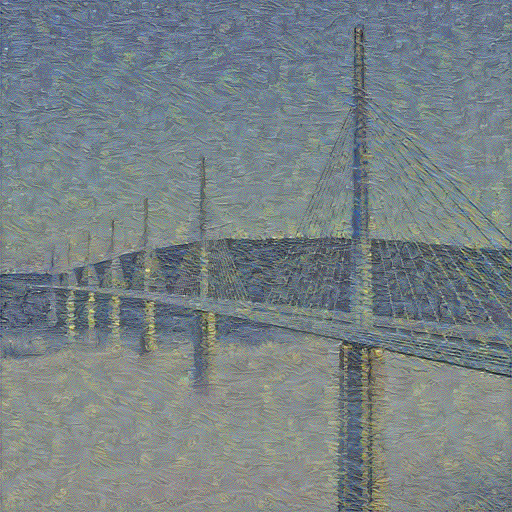

In [94]:
#https://stackoverflow.com/questions/55987302/reversing-the-image-preprocessing-of-vgg-in-keras-to-return-original-image

def reverse_preprocess(x):
    print(x.shape)
    if x.shape != (SIZE, SIZE, 3):
        x = x.reshape((SIZE, SIZE, 3))
    x[..., 0] += 103.939
    x[..., 1] += 116.779
    x[..., 2] += 123.68
    x = x[..., ::-1]
    return x

final_output = reverse_preprocess(x_val.copy())
display(array_to_img(final_output))